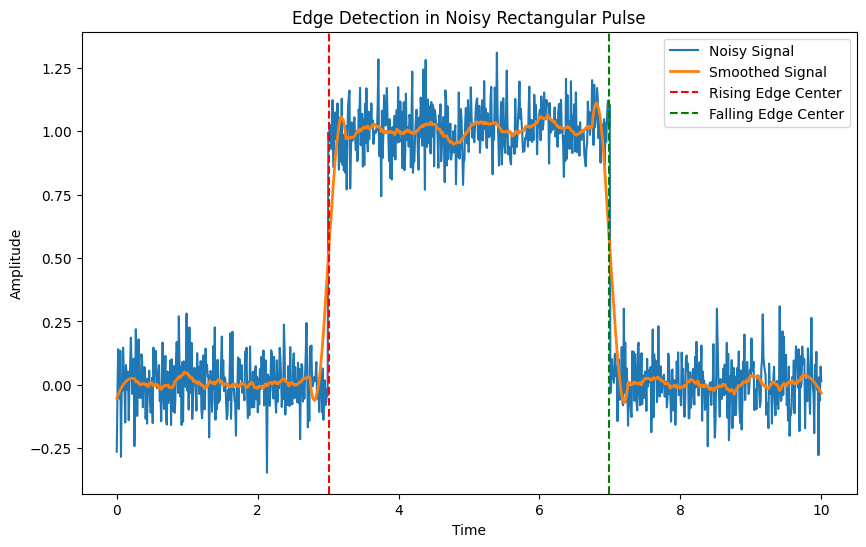

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks

# Example noisy rectangular pulse
t = np.linspace(0, 10, 1000)
signal = np.zeros_like(t)
signal[300:700] = 1  # Rectangular pulse
noise = 0.1 * np.random.randn(len(t))  # Add noise
noisy_signal = signal + noise

# Step 1: Smooth the signal
smoothed_signal = savgol_filter(noisy_signal, window_length=51, polyorder=3)

# Step 2: Compute the derivative
dt = t[1] - t[0]
derivative = np.gradient(smoothed_signal, dt)

# Step 3: Identify edge regions
threshold = 0.5 * np.max(np.abs(derivative))  # Adjust threshold as needed
edge_indices = np.where(np.abs(derivative) > threshold)[0]

# Step 4: Select linear portions and find max slope points
rising_edge_indices = edge_indices[derivative[edge_indices] > 0]
falling_edge_indices = edge_indices[derivative[edge_indices] < 0]

# Find max slope points
rising_edge_center = rising_edge_indices[np.argmax(derivative[rising_edge_indices])]
falling_edge_center = falling_edge_indices[np.argmin(derivative[falling_edge_indices])]

# Step 5: Plot results
plt.figure(figsize=(10, 6))
plt.plot(t, noisy_signal, label="Noisy Signal")
plt.plot(t, smoothed_signal, label="Smoothed Signal", linewidth=2)
plt.axvline(t[rising_edge_center], color='r', linestyle='--', label="Rising Edge Center")
plt.axvline(t[falling_edge_center], color='g', linestyle='--', label="Falling Edge Center")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Edge Detection in Noisy Rectangular Pulse")
plt.show()

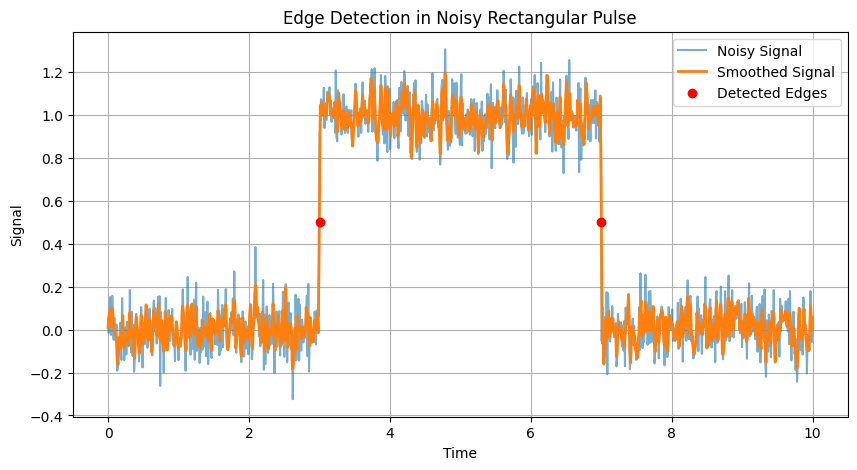

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def find_edges(signal, time, window=5, poly=2, threshold=0.5):
    """ Detects edges in a noisy rectangular pulse.
    
    Args:
        signal (np.array): The noisy signal.
        time (np.array): Time values corresponding to the signal.
        window (int): Window size for Savitzky-Golay filter.
        poly (int): Polynomial order for smoothing.
        threshold (float): Threshold for peak detection in normalized gradient.

    Returns:
        list: Detected edge positions.
    """
    # Smooth the signal to reduce noise
    smooth_signal = savgol_filter(signal, window_length=window, polyorder=poly)

    # Compute the first derivative (gradient)
    gradient = np.gradient(smooth_signal, time)

    # Normalize the gradient
    norm_gradient = gradient / np.max(np.abs(gradient))

    # Find points with the highest slope
    edge_indices = np.where(np.abs(norm_gradient) > threshold)[0]

    # Find the peak points of the slope transitions
    max_slope_indices = []
    for i in range(1, len(edge_indices) - 1):
        if norm_gradient[edge_indices[i - 1]] < norm_gradient[edge_indices[i]] > norm_gradient[edge_indices[i + 1]] or \
           norm_gradient[edge_indices[i - 1]] > norm_gradient[edge_indices[i]] < norm_gradient[edge_indices[i + 1]]:
            max_slope_indices.append(edge_indices[i])

    return time[max_slope_indices]

# Example: Generate a noisy rectangular pulse
np.random.seed(42)
time = np.linspace(0, 10, 1000)
signal = np.piecewise(time, [time < 3, (time >= 3) & (time <= 7), time > 7], [0, 1, 0])
signal += np.random.normal(scale=0.1, size=time.shape)  # Add noise

# Detect edges
edges = find_edges(signal, time)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(time, signal, label="Noisy Signal", alpha=0.6)
plt.plot(time, savgol_filter(signal, window_length=5, polyorder=2), label="Smoothed Signal", linewidth=2)
plt.scatter(edges, [0.5]*len(edges), color='red', marker='o', label="Detected Edges", zorder=3)
plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend()
plt.title("Edge Detection in Noisy Rectangular Pulse")
plt.grid()
plt.show()


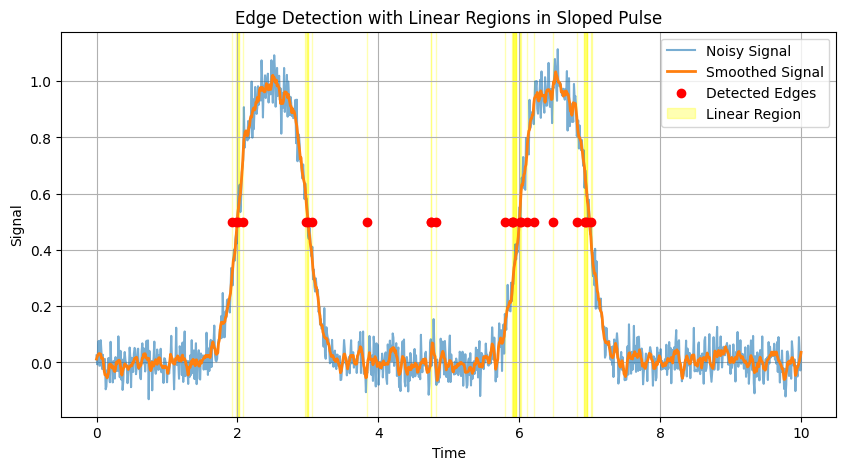

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.stats import linregress

def find_edges_with_linear_regions(signal, time, window=11, poly=2, slope_threshold=0.6, linearity_threshold=0.98):
    """ Detects edges and extracts linear transition regions in a noisy rectangular pulse with sloped edges.
    
    Args:
        signal (np.array): The noisy signal.
        time (np.array): Time values corresponding to the signal.
        window (int): Window size for Savitzky-Golay filter.
        poly (int): Polynomial order for smoothing.
        slope_threshold (float): Threshold for detecting transition points.
        linearity_threshold (float): Minimum R² value for considering a region linear.

    Returns:
        list: Center indices of the edges.
        list: (start, end) indices of the linear regions for each detected edge.
    """
    # Smooth the signal to reduce noise
    smooth_signal = savgol_filter(signal, window_length=window, polyorder=poly)

    # Compute the first derivative (gradient)
    gradient = np.gradient(smooth_signal, time)

    # Normalize the gradient
    norm_gradient = gradient / np.max(np.abs(gradient))

    # Find points where slope magnitude is high
    edge_indices = np.where(np.abs(norm_gradient) > slope_threshold)[0]

    # Find the peak points of the slope transitions
    max_slope_indices = []
    for i in range(1, len(edge_indices) - 1):
        if norm_gradient[edge_indices[i - 1]] < norm_gradient[edge_indices[i]] > norm_gradient[edge_indices[i + 1]] or \
           norm_gradient[edge_indices[i - 1]] > norm_gradient[edge_indices[i]] < norm_gradient[edge_indices[i + 1]]:
            max_slope_indices.append(edge_indices[i])

    # Find linear regions around each edge
    linear_regions = []
    for center_idx in max_slope_indices:
        left_idx, right_idx = center_idx, center_idx

        # Expand leftward
        while left_idx > 1:
            slope, intercept, r_value, _, _ = linregress(time[left_idx-5:left_idx], smooth_signal[left_idx-5:left_idx])
            if r_value**2 < linearity_threshold:
                break
            left_idx -= 1

        # Expand rightward
        while right_idx < len(time) - 5:
            slope, intercept, r_value, _, _ = linregress(time[right_idx:right_idx+5], smooth_signal[right_idx:right_idx+5])
            if r_value**2 < linearity_threshold:
                break
            right_idx += 1

        linear_regions.append((left_idx, right_idx))

    return max_slope_indices, linear_regions

# Example: Generate a noisy rectangular pulse with sloped edges
np.random.seed(42)
time = np.linspace(0, 10, 1000)

# Create a "sloppy" transition (sigmoid-like edges)
def sloppy_pulse(t, t_rise_start, t_rise_end, t_fall_start, t_fall_end):
    return 1 / (1 + np.exp(-(t - t_rise_start) * 10)) - 1 / (1 + np.exp(-(t - t_rise_end) * 10)) + \
           1 / (1 + np.exp(-(t - t_fall_start) * 10)) - 1 / (1 + np.exp(-(t - t_fall_end) * 10))

signal = sloppy_pulse(time, t_rise_start=2, t_rise_end=3, t_fall_start=6, t_fall_end=7)
signal += np.random.normal(scale=0.05, size=time.shape)  # Add noise

# Detect edges and linear regions
edges, linear_regions = find_edges_with_linear_regions(signal, time)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(time, signal, label="Noisy Signal", alpha=0.6)
plt.plot(time, savgol_filter(signal, window_length=11, polyorder=2), label="Smoothed Signal", linewidth=2)
plt.scatter(time[edges], [0.5]*len(edges), color='red', marker='o', label="Detected Edges", zorder=3)

# Highlight linear regions
for start, end in linear_regions:
    plt.axvspan(time[start], time[end], color='yellow', alpha=0.3, label="Linear Region" if start == linear_regions[0][0] else "")

plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend()
plt.title("Edge Detection with Linear Regions in Sloped Pulse")
plt.grid()
plt.show()


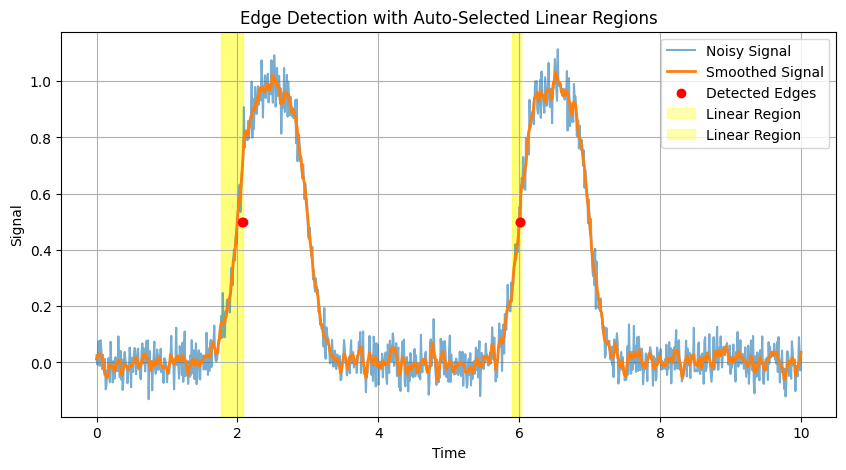

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.stats import linregress

def find_edges_with_linear_regions(signal, time):
    """ Detects edges and extracts linear transition regions in a rectangular pulse.
    
    Automatically determines parameters based on signal properties.
    
    Args:
        signal (np.array): The noisy signal.
        time (np.array): Time values corresponding to the signal.

    Returns:
        list: Center indices of the edges.
        list: (start, end) indices of the linear regions for each detected edge.
    """
    N = len(time)  # Total points
    window_length = max(5, N // 100 | 1)  # ~1% of signal length, must be odd
    polyorder = 2  # Fixed low-order polynomial for smoothing

    # Smooth the signal
    smooth_signal = savgol_filter(signal, window_length=window_length, polyorder=polyorder)

    # Compute the first derivative (gradient)
    gradient = np.gradient(smooth_signal, time)

    # Automatically determine slope threshold: Use top 5% of gradient magnitude
    sorted_grad = np.sort(np.abs(gradient))
    slope_threshold = sorted_grad[int(0.95 * len(sorted_grad))]  

    # Find peak slope points (max positive and negative slopes)
    max_slope_indices = np.argsort(np.abs(gradient))[-4:]  # Take top 4 (2 rising, 2 falling)
    max_slope_indices.sort()  # Ensure correct order

    # Find linear regions around each edge
    linear_regions = []
    gradient_std = np.std(gradient)  # Use gradient deviation to define linearity
    for center_idx in max_slope_indices:
        left_idx, right_idx = center_idx, center_idx

        # Expand leftward until gradient deviates too much
        while left_idx > 1 and np.abs(gradient[left_idx] - gradient[left_idx - 1]) < gradient_std:
            left_idx -= 1

        # Expand rightward until gradient deviates too much
        while right_idx < len(time) - 1 and np.abs(gradient[right_idx] - gradient[right_idx + 1]) < gradient_std:
            right_idx += 1

        linear_regions.append((left_idx, right_idx))

    return max_slope_indices, linear_regions

# Example: Generate a noisy rectangular pulse with sloped edges
np.random.seed(42)
time = np.linspace(0, 10, 1000)

# Create a "sloppy" transition (sigmoid-like edges)
def sloppy_pulse(t, t_rise_start, t_rise_end, t_fall_start, t_fall_end):
    return 1 / (1 + np.exp(-(t - t_rise_start) * 10)) - 1 / (1 + np.exp(-(t - t_rise_end) * 10)) + \
           1 / (1 + np.exp(-(t - t_fall_start) * 10)) - 1 / (1 + np.exp(-(t - t_fall_end) * 10))

signal = sloppy_pulse(time, t_rise_start=2, t_rise_end=3, t_fall_start=6, t_fall_end=7)
signal += np.random.normal(scale=0.05, size=time.shape)  # Add noise

# Detect edges and linear regions
edges, linear_regions = find_edges_with_linear_regions(signal, time)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(time, signal, label="Noisy Signal", alpha=0.6)
plt.plot(time, savgol_filter(signal, window_length=max(5, len(time) // 100 | 1), polyorder=2), label="Smoothed Signal", linewidth=2)
plt.scatter(time[edges], [0.5]*len(edges), color='red', marker='o', label="Detected Edges", zorder=3)

# Highlight linear regions
for start, end in linear_regions:
    plt.axvspan(time[start], time[end], color='yellow', alpha=0.3, label="Linear Region" if start == linear_regions[0][0] else "")

plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend()
plt.title("Edge Detection with Auto-Selected Linear Regions")
plt.grid()
plt.show()


[202, 302] [(198, 208), (266, 314)]


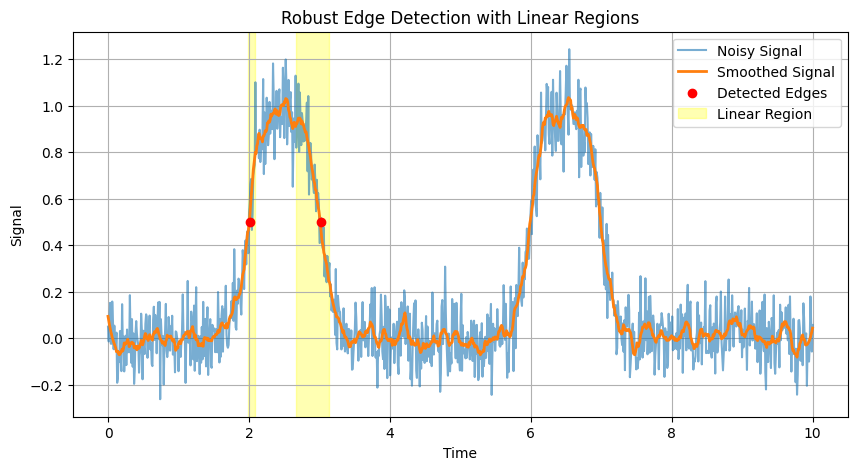

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks

def find_edges_with_linear_regions(signal, time):
    """ Detects edges and extracts linear transition regions in a rectangular pulse.
    
    Uses robust filtering to ignore noise and adaptively selects parameters.

    Args:
        signal (np.array): The noisy signal.
        time (np.array): Time values corresponding to the signal.

    Returns:
        list: Center indices of the edges.
        list: (start, end) indices of the linear regions for each detected edge.
    """
    N = len(time)  # Total points
    window_length = max(5, N // 50 | 1)  # Adaptive smoothing, must be odd
    polyorder = 2  # Low-order polynomial for noise reduction

    # Smooth the signal
    smooth_signal = savgol_filter(signal, window_length=window_length, polyorder=polyorder)

    # Compute the first derivative (gradient)
    gradient = np.gradient(smooth_signal, time)

    # Find the top N% of slopes, avoiding noise spikes
    sorted_grad = np.sort(np.abs(gradient))
    slope_threshold = np.percentile(sorted_grad, 95)  # Use top 5% as threshold

    # Find where the smoothed signal changes the most (detect peaks in abs(gradient))
    peak_indices, _ = find_peaks(np.abs(gradient), height=slope_threshold, distance=N//10)

    # Filter false edges by ensuring detected points correspond to large signal changes
    edge_indices = []
    for idx in peak_indices:
        if abs(smooth_signal[idx] - smooth_signal[0]) > 0.3 * (max(smooth_signal) - min(smooth_signal)):
            edge_indices.append(idx)

    # Ensure we only detect up to 2 edges (assumes a single pulse)
    edge_indices = sorted(edge_indices)[:2]

    # Find linear regions around each detected edge
    linear_regions = []
    gradient_std = np.std(gradient)  # Use gradient deviation to define linearity
    for center_idx in edge_indices:
        left_idx, right_idx = center_idx, center_idx

        # Expand leftward until gradient deviates too much
        while left_idx > 1 and np.abs(gradient[left_idx] - gradient[left_idx - 1]) < gradient_std:
            left_idx -= 1

        # Expand rightward until gradient deviates too much
        while right_idx < len(time) - 1 and np.abs(gradient[right_idx] - gradient[right_idx + 1]) < gradient_std:
            right_idx += 1

        linear_regions.append((left_idx, right_idx))

    return edge_indices, linear_regions

# Example: Generate a noisy rectangular pulse with sloped edges
np.random.seed(42)
time = np.linspace(0, 10, 1000)

# Create a "sloppy" transition (sigmoid-like edges)
def sloppy_pulse(t, t_rise_start, t_rise_end, t_fall_start, t_fall_end):
    return 1 / (1 + np.exp(-(t - t_rise_start) * 10)) - 1 / (1 + np.exp(-(t - t_rise_end) * 10)) + \
           1 / (1 + np.exp(-(t - t_fall_start) * 10)) - 1 / (1 + np.exp(-(t - t_fall_end) * 10))

signal = sloppy_pulse(time, t_rise_start=2, t_rise_end=3, t_fall_start=6, t_fall_end=7)
signal += np.random.normal(scale=0.1, size=time.shape)  # Add larger noise

# Detect edges and linear regions
edges, linear_regions = find_edges_with_linear_regions(signal, time)
print(edges, linear_regions)
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(time, signal, label="Noisy Signal", alpha=0.6)
plt.plot(time, savgol_filter(signal, window_length=max(5, len(time) // 50 | 1), polyorder=2), label="Smoothed Signal", linewidth=2)
plt.scatter(time[edges], [0.5]*len(edges), color='red', marker='o', label="Detected Edges", zorder=3)

# Highlight linear regions
for start, end in linear_regions:
    plt.axvspan(time[start], time[end], color='yellow', alpha=0.3, label="Linear Region" if start == linear_regions[0][0] else "")

plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend()
plt.title("Robust Edge Detection with Linear Regions")
plt.grid()
plt.show()


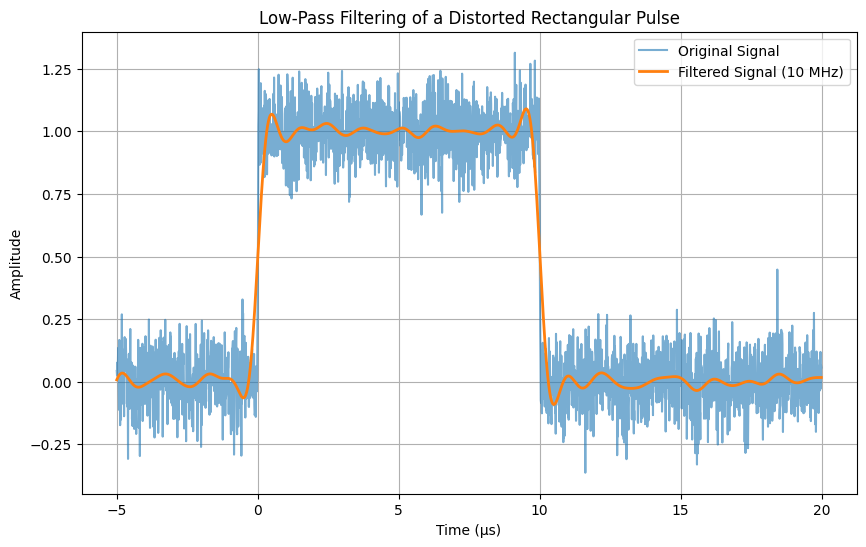

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def generate_pulse(t, width=10e-6):
    """Generates a distorted rectangular pulse with sloped edges and noise."""
    pulse = np.where((t >= 0) & (t <= width), 1, 0)
    pulse = np.convolve(pulse, np.ones(5)/5, mode='same')  # Simulate sloped edges
    noise = 0.1 * np.random.randn(len(t))  # Add noise
    return pulse + noise

def butter_lowpass_filter(data, cutoff, fs, order=5):
    """Applies a low-pass Butterworth filter."""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Define parameters
fs = 100e6  # Sampling frequency 100 MHz
t = np.arange(-5e-6, 20e-6, 1/fs)  # Time vector
pulse = generate_pulse(t)

# Apply low-pass filter
filtered_pulse = butter_lowpass_filter(pulse, 1e6, fs)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t * 1e6, pulse, label='Original Signal', alpha=0.6)
plt.plot(t * 1e6, filtered_pulse, label='Filtered Signal (10 MHz)', linewidth=2)
plt.xlabel('Time (µs)')
plt.ylabel('Amplitude')
plt.title('Low-Pass Filtering of a Distorted Rectangular Pulse')
plt.legend()
plt.grid()
plt.show()


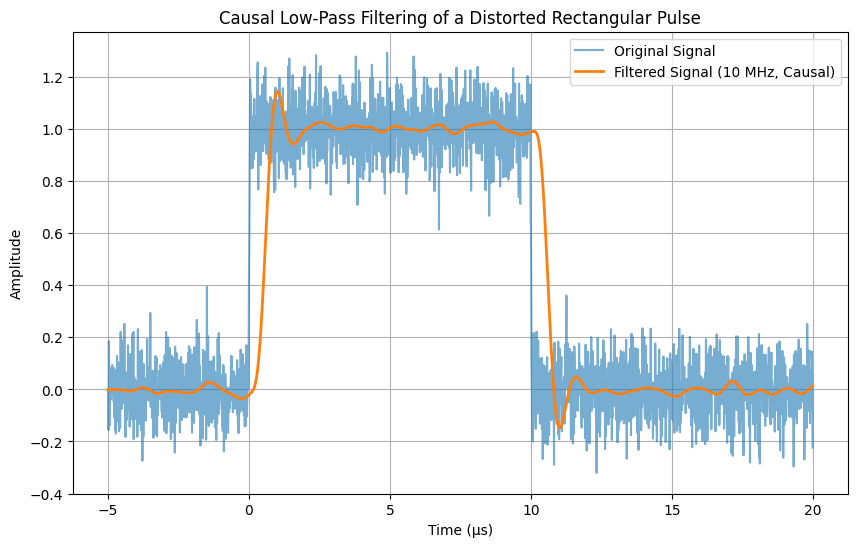

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

def generate_pulse(t, width=10e-6):
    """Generates a distorted rectangular pulse with sloped edges and noise."""
    pulse = np.where((t >= 0) & (t <= width), 1, 0)
    pulse = np.convolve(pulse, np.ones(5)/5, mode='same')  # Simulate sloped edges
    noise = 0.1 * np.random.randn(len(t))  # Add noise
    return pulse + noise

def butter_lowpass(cutoff, fs, order=5):
    """Creates a Butterworth low-pass filter."""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_causal_filter(data, cutoff, fs, order=5):
    """Applies a causal low-pass filter to mimic real-world acquisition."""
    b, a = butter_lowpass(cutoff, fs, order)
    return lfilter(b, a, data)  # Single-pass filter to keep it causal

# Define parameters
fs = 100e6  # Sampling frequency 100 MHz
t = np.arange(-5e-6, 20e-6, 1/fs)  # Time vector
pulse = generate_pulse(t)

# Apply causal low-pass filter
filtered_pulse = apply_causal_filter(pulse, 1e6, fs)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t * 1e6, pulse, label='Original Signal', alpha=0.6)
plt.plot(t * 1e6, filtered_pulse, label='Filtered Signal (10 MHz, Causal)', linewidth=2)
plt.xlabel('Time (µs)')
plt.ylabel('Amplitude')
plt.title('Causal Low-Pass Filtering of a Distorted Rectangular Pulse')
plt.legend()
plt.grid()
plt.show()


Noise Metrics in Plateau Region:
Standard Deviation: 0.1521
Variance: 0.0231
SNR (dB): 16.33


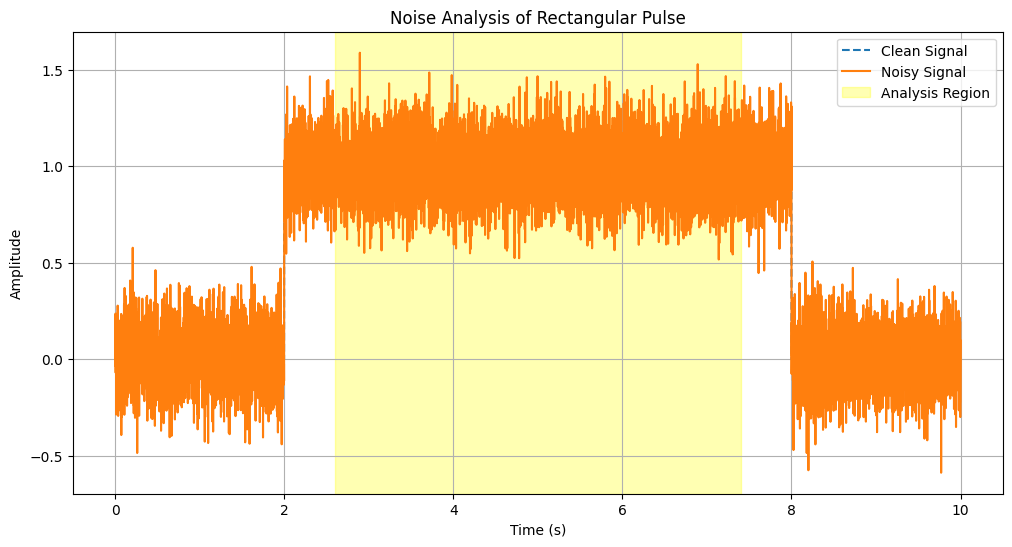

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Signal generation parameters
SAMPLE_RATE = 1000  # Samples per second
DURATION = 10       # Total signal duration in seconds
PULSE_START = 2     # Pulse start time in seconds
PULSE_END = 8       # Pulse end time in seconds
NOISE_STD = 0.15    # Standard deviation of Gaussian noise

# Generate time axis and clean pulse
t = np.linspace(0, DURATION, DURATION * SAMPLE_RATE)
clean_signal = np.zeros_like(t)
clean_signal[(t >= PULSE_START) & (t <= PULSE_END)] = 1

# Add Gaussian noise
np.random.seed(42)  # For reproducibility
noisy_signal = clean_signal + np.random.normal(0, NOISE_STD, len(t))

# Define analysis region (exclude 10% from both edges)
total_pulse_width = PULSE_END - PULSE_START
buffer = total_pulse_width * 0.10  # Exclude 10% from each edge
analysis_start = PULSE_START + buffer
analysis_end = PULSE_END - buffer

# Extract analysis region
analysis_mask = (t >= analysis_start) & (t <= analysis_end)
analysis_signal = noisy_signal[analysis_mask]

# Calculate noise metrics
noise_std = np.std(analysis_signal)
noise_variance = np.var(analysis_signal)
signal_to_noise = 20 * np.log10(np.mean(analysis_signal)/noise_std)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(t, clean_signal, '--', label='Clean Signal')
plt.plot(t, noisy_signal, label='Noisy Signal')
plt.axvspan(analysis_start, analysis_end, color='yellow', alpha=0.3, 
            label='Analysis Region')
plt.title('Noise Analysis of Rectangular Pulse')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Print metrics
print(f"Noise Metrics in Plateau Region:")
print(f"Standard Deviation: {noise_std:.4f}")
print(f"Variance: {noise_variance:.4f}")
print(f"SNR (dB): {signal_to_noise:.2f}")

plt.show()